In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from high_level_features import get_high_level_features

In [3]:
def visualize_groups(classes, groups):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    fig.set_figwidth(20)
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )
    
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw,
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw,
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        # xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
DATASET_DIR = Path("resources/medium_dataset_swstep2/dataset")

## Caricamento del dataset

In [5]:
def load_dataset(dataset_path):
    all_instances = [
        pd.read_csv(path)
        for path in Path(dataset_path).rglob("*.csv") 
    ]
    all_instances = [df for df in all_instances if df.shape[0] > 0]
    dataset = pd.concat(all_instances, ignore_index=True)
    label_map = {"salsa": 1, "bachata": 0}
    dataset["class"] = dataset["label"].map(label_map)
    dataset["group"] = pd.factorize(dataset["name"])[0]
    dataset.drop(["track_id", "first_frame", "last_frame", "name", "label", "window_size"], axis=1, inplace=True)
    return dataset

def display_dataset_stats(dataset):
    print("Dataset shape:", dataset.shape)
    print("Dataset columns:", dataset.columns)
    
    ax = sns.barplot(x=dataset["class"].value_counts().index, y=dataset["class"].value_counts().values)
    ax.bar_label(ax.containers[0])
    plt.title("Class distribution")
    plt.show()
    
    visualize_groups(dataset["class"], dataset["group"])
    plt.title("Distribution of classes and groups")
    plt.show()

In [6]:
dataset = load_dataset(DATASET_DIR)

Dataset shape: (40287, 1692)
Dataset columns: Index(['conf_avg', 'conf_std', 'kp1_x_avg', 'kp1_y_avg', 'kp2_x_avg',
       'kp2_y_avg', 'kp3_x_avg', 'kp3_y_avg', 'kp4_x_avg', 'kp4_y_avg',
       ...
       'f30_kp10_conf', 'f30_kp11_conf', 'f30_kp12_conf', 'f30_kp13_conf',
       'f30_kp14_conf', 'f30_kp15_conf', 'f30_kp16_conf', 'f30_kp17_conf',
       'class', 'group'],
      dtype='object', length=1692)


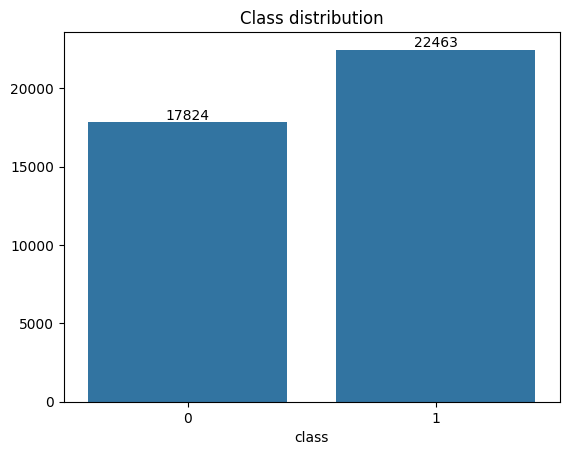

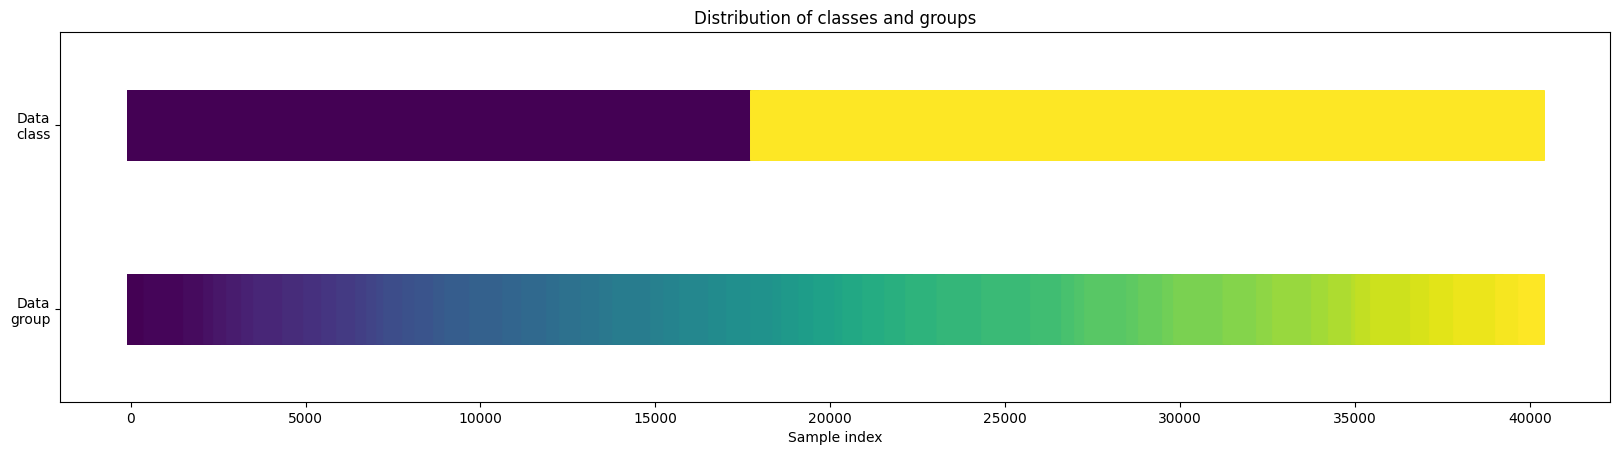

In [7]:
display_dataset_stats(dataset)

## Train/Test Split

- Group Split: evitare che un video abbia osservazioni sia nel training set che nel test set;
- Stratified Split: evitare di avere video di solo una delle due classi nel training set o nel test set.

> Il dataset non viene mischiato.

In scikit-learn non esiste la classe `StratifiedGroupShuffleSplit`, tuttavia è possibile utilizzare `StratifiedGroupKFold` specificando $n\_splits=\frac{1}{test\_size}$ e poi selezionare in modo casuale uno degli split restituiti.

Tuttavia soddisfare entrambi i criteri non è sempre possibile e ciò dipende in gran parte dalla quantità di dati a disposizione e dalla dimensione desiderata per il test set.

Notare come con il dataset "small" e un test set del 10% non sia possibile ottenere un test set con entrambe le classi (vedere figura sotto).

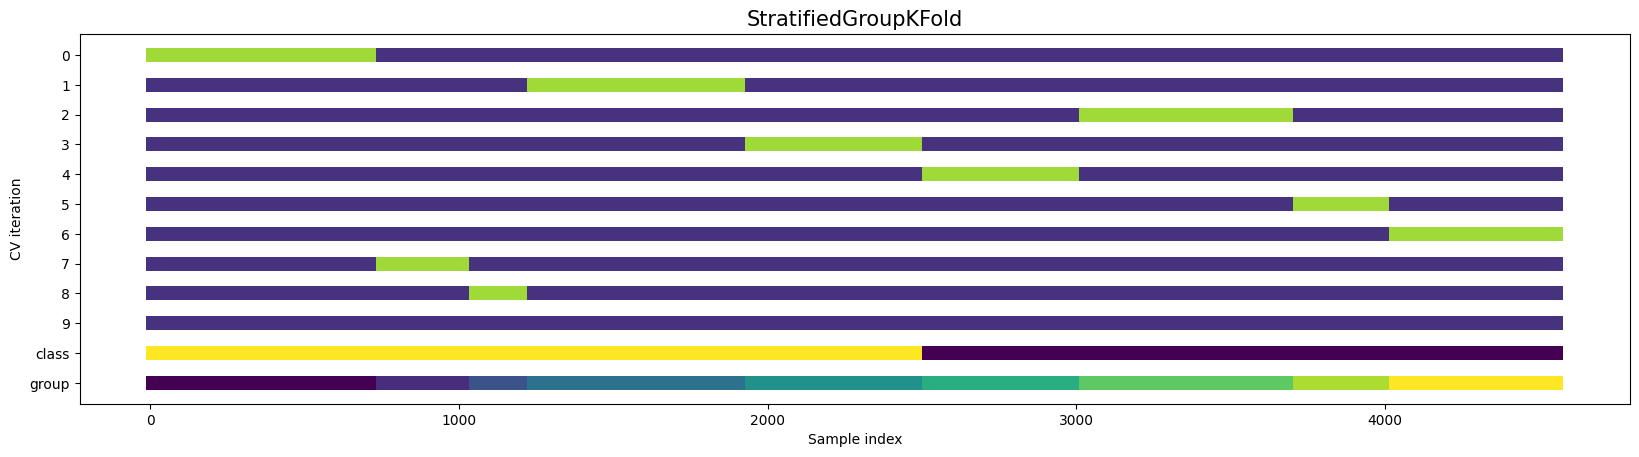

Per effettuare lo split Train-Test, utilizziamo `StratifiedGroupKFold` e prendiamo il primo split restituito **che include entrambe le classi**. Se non esiste uno split di questo tipo, dobbiamo per forza fallire.

In [8]:
def train_test_split_by_group(dataset, groups, test_size: float, shuffle: bool, random_state: int|None = None, return_indices: bool = False):
    n_splits = int(1 / test_size)
    if shuffle:
        cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    else:
        cv = StratifiedGroupKFold(n_splits=n_splits)
    
    splits = cv.split(X=dataset, y=dataset["class"], groups=groups)
    valid_split_found = False
    train, test = None, None
    while not valid_split_found:
        train_indx, test_indx = next(splits)
        n_classes_in_train = dataset.iloc[train_indx]["class"].nunique()
        n_classes_in_test = dataset.iloc[test_indx]["class"].nunique()
        both_classes_in_both_sets = n_classes_in_train == 2 and n_classes_in_test == 2
        if both_classes_in_both_sets:
            valid_split_found = True
            if return_indices:
                train, test = train_indx, test_indx
            else:
                train, test = dataset.iloc[train_indx], dataset.iloc[test_indx]
        
    if train is None or test is None:
        raise ValueError("Could not find a valid split. Please try with a different test_size or random_state.")
    return train, test

In [9]:
groups = dataset["group"]
train_idx, test_idx = train_test_split_by_group(dataset, groups, test_size=TEST_SIZE, shuffle=False, return_indices=True)

In [10]:
training_set, test_set = train_test_split_by_group(dataset, groups, test_size=TEST_SIZE, shuffle=False)

In [11]:
training_set

,conf_avg,conf_std,kp1_x_avg,kp1_y_avg,kp2_x_avg,kp2_y_avg,kp3_x_avg,kp3_y_avg,kp4_x_avg,kp4_y_avg,...,f30_kp10_conf,f30_kp11_conf,f30_kp12_conf,f30_kp13_conf,f30_kp14_conf,f30_kp15_conf,f30_kp16_conf,f30_kp17_conf,class,group
0,0.896822,0.029837,0.324967,0.123154,0.371616,0.100508,0.312131,0.102659,0.525431,0.101054,...,0.91007,0.32380,0.99534,0.98242,0.99491,0.97792,0.98605,0.96087,0,0
1,0.689289,0.218768,0.286350,0.118210,0.337347,0.095856,0.273718,0.092968,0.501211,0.096111,...,0.30349,0.17347,0.94943,0.93683,0.95364,0.93836,0.94250,0.93367,0,0
2,0.641130,0.179016,0.320885,0.117690,0.373388,0.094769,0.299976,0.089236,0.535004,0.091685,...,0.96484,0.48208,0.99210,0.96485,0.98047,0.90479,0.91503,0.77110,0,0
3,0.812327,0.057071,0.411121,0.111669,0.457886,0.089418,0.400481,0.072798,0.614616,0.087928,...,0.96913,0.60449,0.99404,0.97825,0.98501,0.93426,0.93639,0.84044,0,0
4,0.857752,0.034459,0.393355,0.115503,0.430613,0.091879,0.396987,0.077563,0.585729,0.085721,...,0.96998,0.88365,0.99252,0.98382,0.98061,0.95809,0.91236,0.86608,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40282,0.880001,0.030558,0.124651,0.114934,0.159516,0.093176,0.250050,0.082128,0.299858,0.095068,...,0.99281,0.28564,0.99852,0.98585,0.99801,0.97601,0.98933,0.92826,1,65
40283,0.668579,0.251509,0.641454,0.124993,0.693009,0.098370,0.572838,0.096295,0.931743,0.142218,...,0.90074,0.23127,0.96922,0.86552,0.87269,0.47663,0.64153,0.23125,1,65
40284,0.582160,0.196767,0.606529,0.129121,0.648199,0.106365,0.540418,0.101500,0.943404,0.153286,...,0.89213,0.29842,0.99245,0.97303,0.97106,0.86083,0.88983,0.65050,1,65
40285,0.668478,0.255762,0.636028,0.124282,0.687185,0.098804,0.568677,0.095411,0.931894,0.143214,...,0.89195,0.20289,0.96688,0.85247,0.86675,0.45380,0.65489,0.23392,1,65


Dataset shape: (32089, 1692)
Dataset columns: Index(['conf_avg', 'conf_std', 'kp1_x_avg', 'kp1_y_avg', 'kp2_x_avg',
       'kp2_y_avg', 'kp3_x_avg', 'kp3_y_avg', 'kp4_x_avg', 'kp4_y_avg',
       ...
       'f30_kp10_conf', 'f30_kp11_conf', 'f30_kp12_conf', 'f30_kp13_conf',
       'f30_kp14_conf', 'f30_kp15_conf', 'f30_kp16_conf', 'f30_kp17_conf',
       'class', 'group'],
      dtype='object', length=1692)


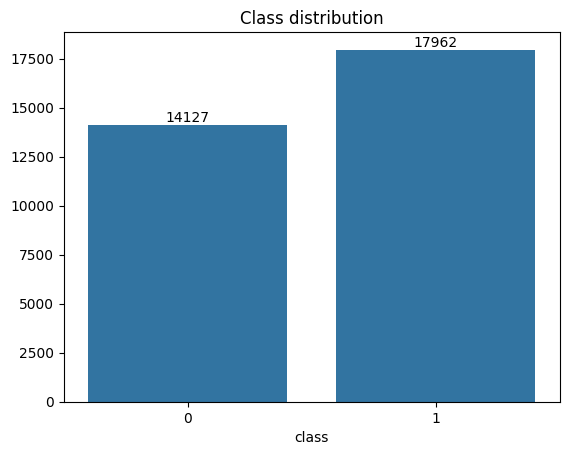

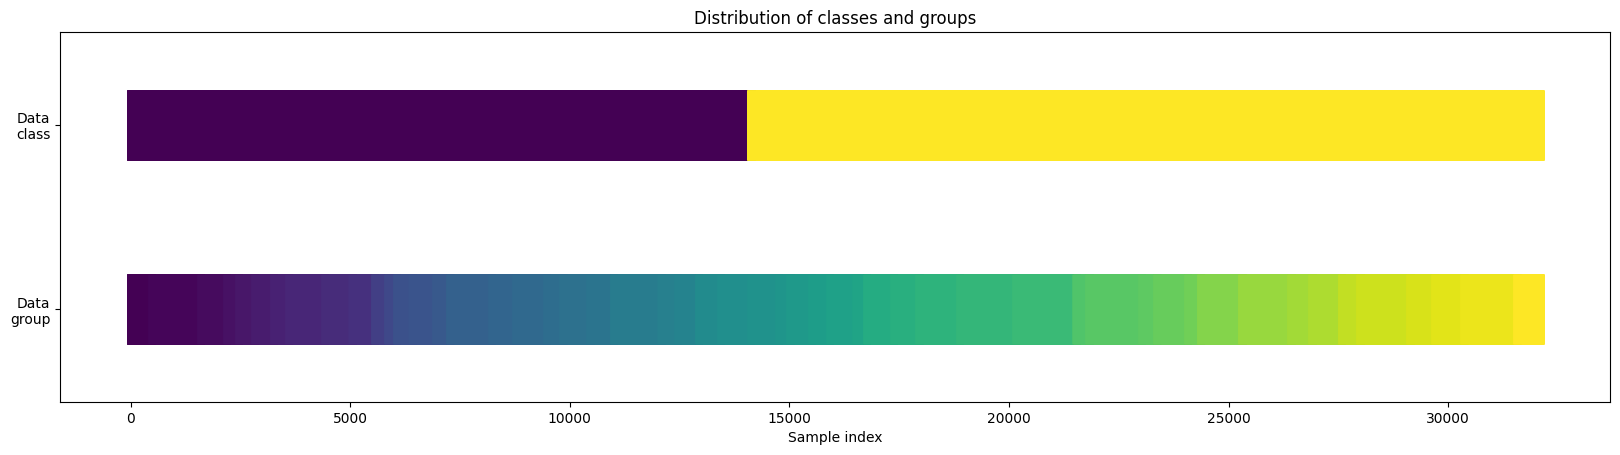

In [12]:
display_dataset_stats(training_set)

In [13]:
test_set

,conf_avg,conf_std,kp1_x_avg,kp1_y_avg,kp2_x_avg,kp2_y_avg,kp3_x_avg,kp3_y_avg,kp4_x_avg,kp4_y_avg,...,f30_kp10_conf,f30_kp11_conf,f30_kp12_conf,f30_kp13_conf,f30_kp14_conf,f30_kp15_conf,f30_kp16_conf,f30_kp17_conf,class,group
5557,0.812372,0.051074,0.200182,0.119181,0.237740,0.095426,0.078318,0.000000,0.386888,0.084959,...,0.94824,0.22987,0.99400,0.97148,0.99178,0.94734,0.96530,0.85903,0,10
5558,0.796348,0.022223,0.142034,0.113729,0.181512,0.090684,0.196077,0.000000,0.340959,0.086901,...,0.88290,0.28982,0.98781,0.96352,0.97840,0.91725,0.91056,0.77266,0,10
5559,0.787076,0.029460,0.225222,0.098733,0.273487,0.077663,0.268758,0.025755,0.422876,0.082153,...,0.91959,0.31072,0.98823,0.96009,0.97807,0.90885,0.90441,0.75126,0,10
5560,0.800985,0.038510,0.325318,0.081357,0.385121,0.062675,0.289410,0.052809,0.540618,0.071076,...,0.95397,0.36312,0.99100,0.96654,0.98244,0.91896,0.92011,0.77698,0,10
5561,0.780686,0.050822,0.420668,0.080739,0.485130,0.064080,0.387621,0.064174,0.623397,0.081137,...,0.97490,0.70590,0.99315,0.98256,0.99230,0.97362,0.96760,0.91872,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39771,0.902291,0.014019,0.276811,0.117921,0.316768,0.093004,0.280282,0.097796,0.484457,0.079784,...,0.97347,0.48554,0.99729,0.98476,0.99831,0.98942,0.99554,0.98391,1,64
39772,0.897472,0.018384,0.202513,0.128475,0.233499,0.103570,0.226696,0.118128,0.406029,0.088127,...,0.96615,0.77764,0.99586,0.98937,0.99433,0.98369,0.98381,0.96777,1,64
39773,0.870691,0.027172,0.298770,0.132848,0.335480,0.108327,0.277182,0.122779,0.500236,0.092866,...,0.95456,0.85066,0.99641,0.99335,0.99462,0.98866,0.98240,0.96992,1,64
39774,0.840253,0.050322,0.441119,0.128488,0.478037,0.103840,0.399329,0.107452,0.616234,0.085237,...,0.98528,0.95991,0.99771,0.99599,0.99633,0.99295,0.97879,0.96789,1,64


Dataset shape: (8198, 1692)
Dataset columns: Index(['conf_avg', 'conf_std', 'kp1_x_avg', 'kp1_y_avg', 'kp2_x_avg',
       'kp2_y_avg', 'kp3_x_avg', 'kp3_y_avg', 'kp4_x_avg', 'kp4_y_avg',
       ...
       'f30_kp10_conf', 'f30_kp11_conf', 'f30_kp12_conf', 'f30_kp13_conf',
       'f30_kp14_conf', 'f30_kp15_conf', 'f30_kp16_conf', 'f30_kp17_conf',
       'class', 'group'],
      dtype='object', length=1692)


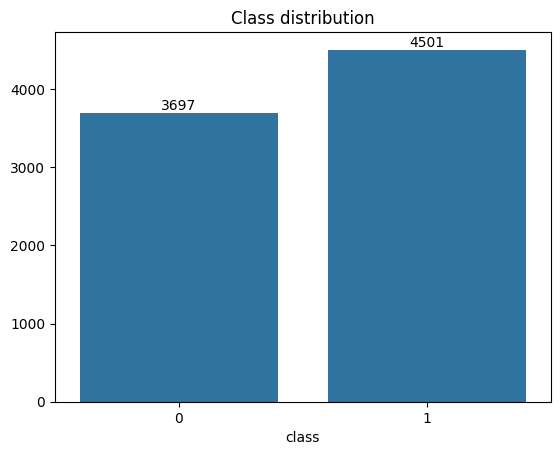

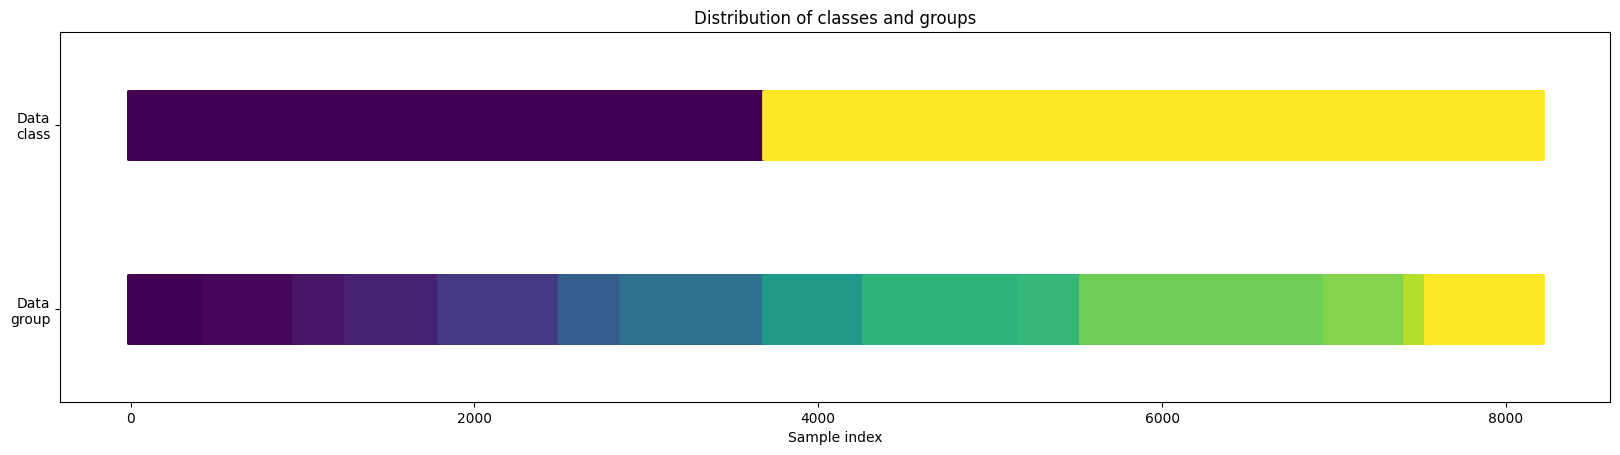

In [14]:
display_dataset_stats(test_set)

## Validation Set

Con il dataset "small" fare una k-Fold CV con k elevato significa utilizzare la maggior parte dei dati di training ma ogni fold contiene solo una delle due classi.

Usando il dataset "medium" invece può richiedere molto tempo. Proviamo con 5-fold. Dovrebbe approssimare bene il generalization error.

In [15]:
train_groups = training_set["group"]
X_train, y_train = training_set.drop(["class", "group"], axis=1), training_set["class"]
X_test, y_test = test_set.drop(["class", "group"], axis=1), test_set["class"]

In [16]:
VALIDATION_SIZE = 0.2

<Axes: title={'center': 'StratifiedGroupKFold'}, xlabel='Sample index', ylabel='CV iteration'>

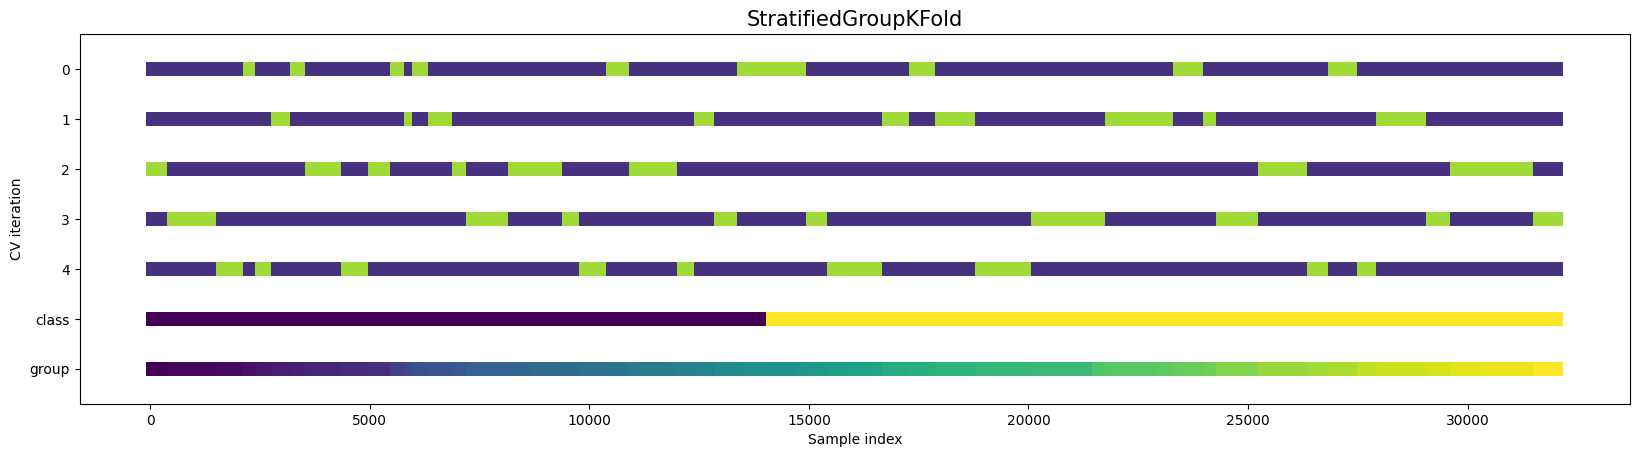

In [17]:
val_cv = StratifiedGroupKFold(n_splits=int(1/VALIDATION_SIZE), shuffle=True, random_state=42)

fig, ax = plt.subplots()
fig.set_figwidth(20)
plot_cv_indices(val_cv, X_train, y_train, train_groups, ax, int(1/VALIDATION_SIZE))

Notiamo sotto come tutti i training set della CV siano sbilanciati in favore della classe 1 (del resto, come il dataset iniziale).

In [18]:
for train_idx, val_idx in val_cv.split(X_train, y_train, train_groups):
    print("--- fold ---")
    print("Train size:", len(train_idx))
    class_proportions = y_train.iloc[train_idx].value_counts(normalize=True)
    print(f"Class distribution in train set: {class_proportions[0]:.2f} bachata, {class_proportions[1]:.2f} salsa")
    class_absolute = y_train.iloc[train_idx].value_counts()
    print(f"Absolute class distribution in train set: {class_absolute[0]} bachata, {class_absolute[1]} salsa")
    print("Validation size:", len(val_idx))
    print()

--- fold ---
Train size: 26736
Class distribution in train set: 0.43 bachata, 0.57 salsa
Absolute class distribution in train set: 11623 bachata, 15113 salsa
Validation size: 5353

--- fold ---
Train size: 25958
Class distribution in train set: 0.48 bachata, 0.52 salsa
Absolute class distribution in train set: 12503 bachata, 13455 salsa
Validation size: 6131

--- fold ---
Train size: 24647
Class distribution in train set: 0.39 bachata, 0.61 salsa
Absolute class distribution in train set: 9677 bachata, 14970 salsa
Validation size: 7442

--- fold ---
Train size: 24942
Class distribution in train set: 0.45 bachata, 0.55 salsa
Absolute class distribution in train set: 11161 bachata, 13781 salsa
Validation size: 7147

--- fold ---
Train size: 26073
Class distribution in train set: 0.44 bachata, 0.56 salsa
Absolute class distribution in train set: 11544 bachata, 14529 salsa
Validation size: 6016



## Estrazione features

In [19]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [20]:
X_train_high_level = get_high_level_features(X_train, window_size=30, include_face_keypoints=True)

c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountered in divide
  np.arccos((dot_product / normalization_factor).clip(-1, 1)),
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountered in divide
  np.arccos((dot_product / normalization_factor).clip(-1, 1)),
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountered in divide
  np.arccos((dot_product / normalization_factor).clip(-1, 1)),
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountered in divide
  np.arccos((dot_product / normalization_factor).clip(-1, 1)),
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountere

In [21]:
X_train_high_level

,conf_avg,conf_std,kp1_x_avg,kp1_y_avg,kp2_x_avg,kp2_y_avg,kp3_x_avg,kp3_y_avg,kp4_x_avg,kp4_y_avg,...,f21_angle_13_15_17,f22_angle_13_15_17,f23_angle_13_15_17,f24_angle_13_15_17,f25_angle_13_15_17,f26_angle_13_15_17,f27_angle_13_15_17,f28_angle_13_15_17,f29_angle_13_15_17,f30_angle_13_15_17
0,0.896822,0.029837,0.324967,0.123154,0.371616,0.100508,0.312131,0.102659,0.525431,0.101054,...,148.856704,134.819341,125.536021,124.204002,131.526316,137.216070,143.707072,148.989550,140.494299,140.239035
1,0.689289,0.218768,0.286350,0.118210,0.337347,0.095856,0.273718,0.092968,0.501211,0.096111,...,165.367482,159.921896,155.656796,159.204173,169.787172,178.003400,178.835867,179.869914,179.344494,175.650048
2,0.641130,0.179016,0.320885,0.117690,0.373388,0.094769,0.299976,0.089236,0.535004,0.091685,...,167.856961,168.343645,170.731138,169.563349,170.641118,165.896930,154.504663,152.047075,152.724928,146.245164
3,0.812327,0.057071,0.411121,0.111669,0.457886,0.089418,0.400481,0.072798,0.614616,0.087928,...,106.683166,114.830399,131.176245,145.856409,160.676060,175.464873,169.441372,159.133365,161.668335,170.210992
4,0.857752,0.034459,0.393355,0.115503,0.430613,0.091879,0.396987,0.077563,0.585729,0.085721,...,174.957160,170.921981,171.152995,173.585051,179.334663,172.238434,159.849405,159.942293,168.182458,168.741639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32084,0.880001,0.030558,0.124651,0.114934,0.159516,0.093176,0.250050,0.082128,0.299858,0.095068,...,107.749512,109.136899,105.073763,101.133737,109.807732,117.883200,121.555367,109.693253,95.406111,93.119480
32085,0.668579,0.251509,0.641454,0.124993,0.693009,0.098370,0.572838,0.096295,0.931743,0.142218,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.689503,166.518688,174.042117,177.482850
32086,0.582160,0.196767,0.606529,0.129121,0.648199,0.106365,0.540418,0.101500,0.943404,0.153286,...,167.726140,169.924972,174.409762,179.345850,169.648636,162.206869,159.213702,162.417552,176.854834,166.420904
32087,0.668478,0.255762,0.636028,0.124282,0.687185,0.098804,0.568677,0.095411,0.931894,0.143214,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,167.265490,171.505201,176.987827,178.105122


## Curve di apprendimento

Testiamo l'ipotesi che l'aggiunta di più dati conduca a delle prestazioni migliori.

- Scegliamo alcune dimensioni da testare in modo crescente. Per ogni size considerata:
    - Prendiamo il training set a disposizione e facciamo la 5-fold
    - Per ogni split:
        - Il training set risultante viene sottocampionato in modo da avere la size considerata **e il bilanciamento tra le classi** (in pratica si usa `RandomUnderSampler`)
        - Si testa sul validation set risultante

In [22]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from imblearn.under_sampling import RandomUnderSampler

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
val_cv = StratifiedGroupKFold(n_splits=int(1/VALIDATION_SIZE), shuffle=True, random_state=RANDOM_STATE)

In [25]:
train_scores = []
val_scores = []

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

sizes = [1000, 5000, 10000, 15000, 19200]
for size in sizes:
    print(f"Training size: {size}")
    
    trains = []
    vals = []
    for train_idx, val_idx in val_cv.split(X_train, y_train, groups=train_groups):
        X_train_split, X_val_split, y_train_split, y_val_split = \
            X_train.iloc[train_idx], X_train.iloc[val_idx], y_train[train_idx], y_train[val_idx]
        
        rus = RandomUnderSampler(random_state=42, sampling_strategy={0: int(size/2), 1: int(size/2)})
        X_subset, y_subset = rus.fit_resample(X_train_split, y_train_split)
        
        training_class_count = y_subset.value_counts()
        class_absolute = y_train.iloc[train_idx].value_counts()
        print(f"- Training class distribution before resampling: [{class_absolute[0]}, {class_absolute[1]}]")
        
        model.fit(X_subset, y_subset)
        y_train_pred = model.predict(X_subset)
        y_val_pred = model.predict(X_val_split)
        
        trains.append(f1_score(y_subset, y_train_pred, average="macro"))
        vals.append(f1_score(y_val_split, y_val_pred, average="macro"))
    train_scores.append(trains)
    val_scores.append(vals)
    print(f"Mean training score (f1): {np.mean(trains)}, std: {np.std(trains)}")
    print(f"Validation scores (f1): {vals}")
    print(f"Mean validation score (f1): {np.mean(vals)}, std: {np.std(vals)}")
    print()
    print()
    print("--------------------------------------------------")
    print()

Training size: 1000
- Training class distribution before resampling: [11623, 15113]
- Training class distribution before resampling: [12503, 13455]
- Training class distribution before resampling: [9677, 14970]
- Training class distribution before resampling: [11161, 13781]
- Training class distribution before resampling: [11544, 14529]
Mean training score (f1): 1.0, std: 0.0
Validation scores (f1): [0.6753348457341717, 0.5906203724696841, 0.5527407965535266, 0.5252039704507507, 0.5830839603283173]
Mean validation score (f1): 0.5853967891072902, std: 0.050618333234936475


--------------------------------------------------

Training size: 5000
- Training class distribution before resampling: [11623, 15113]
- Training class distribution before resampling: [12503, 13455]
- Training class distribution before resampling: [9677, 14970]
- Training class distribution before resampling: [11161, 13781]
- Training class distribution before resampling: [11544, 14529]
Mean training score (f1): 1.0

(0.0, 1.1)

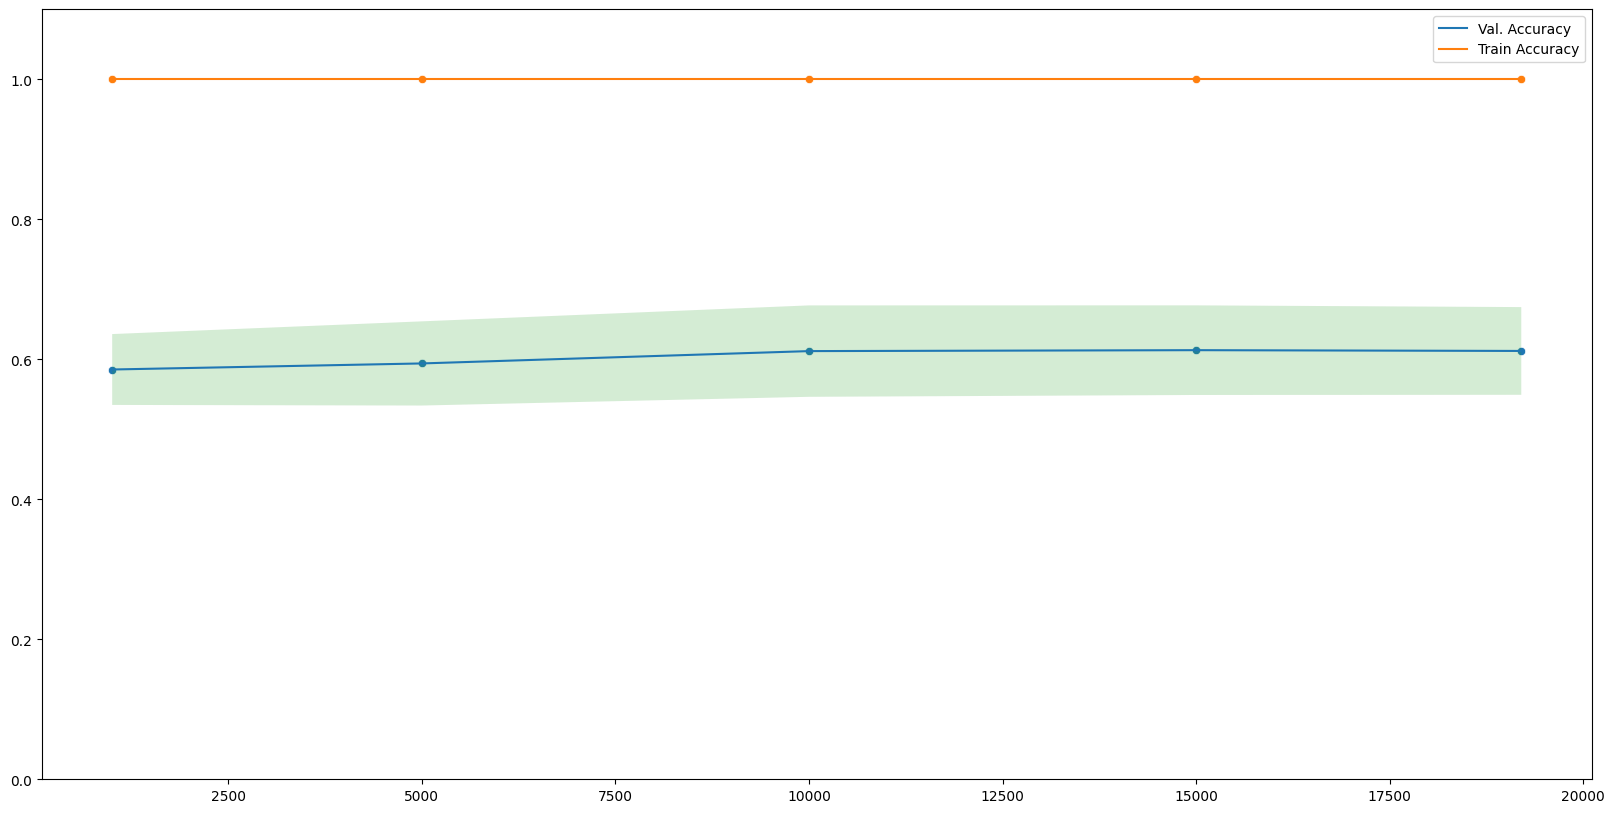

In [26]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

mean_val_scores = np.mean(val_scores, axis=1)
sns.lineplot(x=sizes, y=mean_val_scores, label="Val. Score")
sns.scatterplot(x=sizes, y=mean_val_scores)

mean_train_scores = np.mean(train_scores, axis=1)
sns.lineplot(x=sizes, y=mean_train_scores, label="Train Score")
sns.scatterplot(x=sizes, y=mean_train_scores)

plt.fill_between(sizes, mean_val_scores - np.std(val_scores, axis=1), mean_val_scores + np.std(val_scores, axis=1), alpha=0.2)
plt.fill_between(sizes, mean_train_scores - np.std(train_scores, axis=1), mean_train_scores + np.std(train_scores, axis=1), alpha=0.2)
plt.ylim(0, 1.1)

## Learning curves con PCA

In [27]:
from sklearn.decomposition import PCA
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler

pipeline = make_pipeline_with_sampler(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    PCA(n_components=0.999),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

In [28]:
train_scores = []
val_scores = []

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

sizes = [1000, 5000, 10000, 15000, 19200]
for size in sizes:
    print(f"Training size: {size}")
    
    trains = []
    vals = []
    for train_idx, val_idx in val_cv.split(X_train, y_train, groups=train_groups):
        X_train_split, X_val_split, y_train_split, y_val_split = \
            X_train.iloc[train_idx], X_train.iloc[val_idx], y_train[train_idx], y_train[val_idx]
        
        pipeline.set_params(randomundersampler__sampling_strategy={0: int(size/2), 1: int(size/2)})
        pipeline.fit(X_train_split, y_train_split)
        
        X_subset, y_subset = pipeline['randomundersampler'].fit_resample(X_train_split, y_train_split)
        training_class_count = y_subset.value_counts()
        class_absolute = y_train.iloc[train_idx].value_counts()
        print(f"- Training class distribution before resampling: [{class_absolute[0]}, {class_absolute[1]}]")
        
        print(f"    - PCA components: {pipeline['pca'].n_components_}")
        y_train_pred = pipeline.predict(X_subset)
        y_val_pred = pipeline.predict(X_val_split)
        
        trains.append(f1_score(y_subset, y_train_pred, average="macro"))
        vals.append(f1_score(y_val_split, y_val_pred, average="macro"))
    train_scores.append(trains)
    val_scores.append(vals)
    print(f"Mean training score (f1): {np.mean(trains)}, std: {np.std(trains)}")
    print(f"Validation scores (f1): {vals}")
    print(f"Mean validation score (f1): {np.mean(vals)}, std: {np.std(vals)}")
    print("--------------------------------------------------")
    print()

Training size: 1000
- Training class distribution before resampling: [11623, 15113]
    - PCA components: 649
- Training class distribution before resampling: [12503, 13455]
    - PCA components: 644
- Training class distribution before resampling: [9677, 14970]
    - PCA components: 640
- Training class distribution before resampling: [11161, 13781]
    - PCA components: 645
- Training class distribution before resampling: [11544, 14529]
    - PCA components: 652
Mean training score (f1): 1.0, std: 0.0
Validation scores (f1): [0.5569189806574106, 0.5269006318896438, 0.5192450505422723, 0.5046524418738508, 0.543863326695315]
Mean validation score (f1): 0.5303160863316986, std: 0.018352642955879295
--------------------------------------------------

Training size: 5000
- Training class distribution before resampling: [11623, 15113]
    - PCA components: 909
- Training class distribution before resampling: [12503, 13455]
    - PCA components: 906
- Training class distribution before resa

(0.0, 1.1)

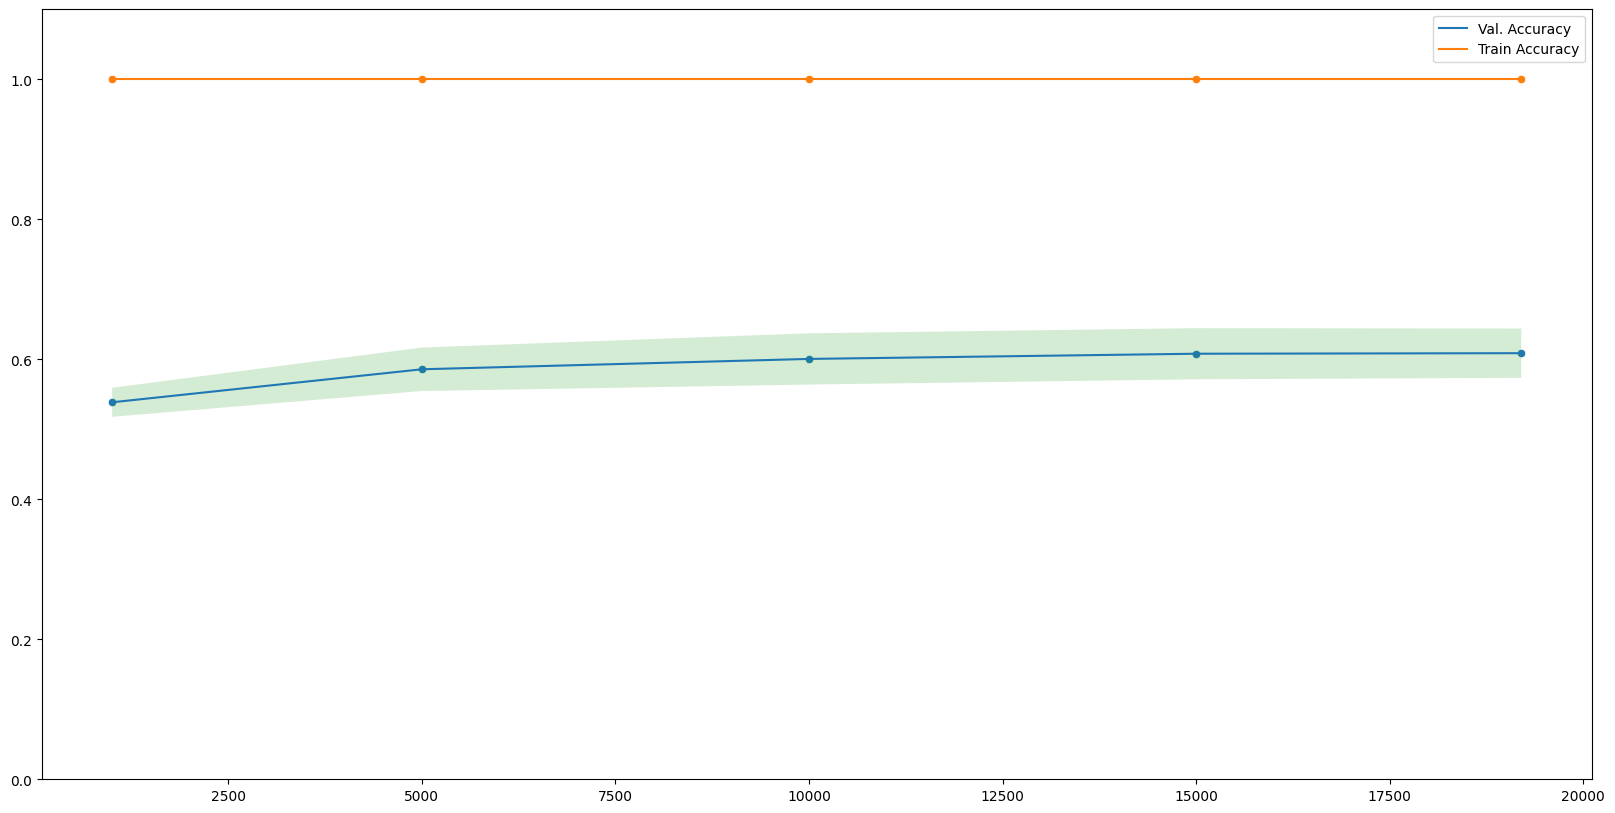

In [86]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

mean_val_scores = np.mean(val_scores, axis=1)
sns.lineplot(x=sizes, y=mean_val_scores, label="Val. Score")
sns.scatterplot(x=sizes, y=mean_val_scores)

mean_train_scores = np.mean(train_scores, axis=1)
sns.lineplot(x=sizes, y=mean_train_scores, label="Train Score")
sns.scatterplot(x=sizes, y=mean_train_scores)

plt.fill_between(sizes, mean_val_scores - np.std(val_scores, axis=1), mean_val_scores + np.std(val_scores, axis=1), alpha=0.2)
plt.fill_between(sizes, mean_train_scores - np.std(train_scores, axis=1), mean_train_scores + np.std(train_scores, axis=1), alpha=0.2)
plt.ylim(0, 1.1)

## SMOTE

In [87]:
from imblearn.over_sampling import SMOTE

train_scores = []
val_scores = []
train_accuracies = []
val_accuracies = []

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

sizes = [1000, 5000, 10000, 15000, 26800]
    
train_scores = []
val_bal_accs = []
train_accs = []
val_accs = []
for train_idx, val_idx in val_cv.split(X_train, y_train, groups=train_groups):
    X_train_split, X_val_split, y_train_split, y_val_split = \
        X_train.iloc[train_idx], X_train.iloc[val_idx], y_train[train_idx], y_train[val_idx]
    
    smote = SMOTE(random_state=42)
    X_subset, y_subset = smote.fit_resample(X_train_split, y_train_split)
    
    training_class_count = y_subset.value_counts()
    class_absolute = y_train.iloc[train_idx].value_counts()
    print(f"- Training class distribution before resampling: [{class_absolute[0]}, {class_absolute[1]}]")
    
    print(f"- Training class distribution after resampling: [{training_class_count[0]}, {training_class_count[1]}]")
    
    pipeline.fit(X_subset, y_subset)
    print(f"    - PCA components: {pipeline['pca'].n_components_}")
    y_train_pred = pipeline.predict(X_subset)
    y_val_pred = pipeline.predict(X_val_split)
    
    train_score = balanced_accuracy_score(y_subset, y_train_pred)
    val_score = balanced_accuracy_score(y_val_split, y_val_pred)
    train_acc = accuracy_score(y_subset, y_train_pred)
    val_acc = accuracy_score(y_val_split, y_val_pred)
    
    train_scores.append(train_score)
    val_bal_accs.append(val_score)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
train_scores.append(train_scores)
print(f"Mean training score: {np.mean(train_scores)}, std: {np.std(train_scores)}")
val_scores.append(val_bal_accs)
print(f"Validation scores: {val_bal_accs}")
print(f"Mean validation score: {np.mean(val_bal_accs)}, std: {np.std(val_bal_accs)}")
print()

- Training class distribution before resampling: [11623, 15113]
- Training class distribution after resampling: [15113, 15113]
    - PCA components: 955
- Training class distribution before resampling: [12503, 13455]
- Training class distribution after resampling: [13455, 13455]
    - PCA components: 957
- Training class distribution before resampling: [9677, 14970]
- Training class distribution after resampling: [14970, 14970]
    - PCA components: 943
- Training class distribution before resampling: [11161, 13781]
- Training class distribution after resampling: [13781, 13781]
    - PCA components: 946
- Training class distribution before resampling: [11544, 14529]
- Training class distribution after resampling: [14529, 14529]
    - PCA components: 958
Mean training score: 0.9324526054208532, std: 0.009553707008588389
Validation scores: [0.5880975837046125, 0.6840725865949082, 0.536032791564021, 0.6089747828494927, 0.58906714779769]
Mean validation score: 0.6012489785021449, std: 0.04

Forse è una mia impressione, ma il classificatore sembra comportarsi meglio con il dataset "naturalmente" bilanciato.